# Track Simulation and Classification using ML

This notebook simulates track diffusion in 2D in immobile, fast diffusion, and slow diffusion states.  Then it classifies these tracks into segments using recursive networks.

Let's first import all needed libraries.

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.special import gamma

# Importing and settings
import matplotlib.pyplot as plt
from matplotlib import cm
import math
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
import numpy as np

# Import stuff for training
import keras
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers.core import Dense  #,Dropout ?
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN as sRNN
import tensorflow as tf

from keras.callbacks import EarlyStopping

import os
import scipy
import pickle

if len(tf.config.list_physical_devices(device_type='GPU')) > 0:
    devices = tf.config.list_physical_devices(device_type='GPU')
    tf.config.experimental.set_memory_growth(devices[1], enable=True)
    tf.config.experimental.set_memory_growth(devices[0], enable=True)
else:
    devices = tf.config.list_physical_devices(device_type='CPU')

2023-06-05 14:50:28.885685: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [3]:
# Image size in pixels
image_size = (512, 512)
# How many tracks do we simulate?
number_of_simulated_tracks = 10000
# Which diffusion coefficients are "slow" and "fast"
diffusion_coefficients = [1.0, 2.0]
# Immobile state hurst coefficients
hurst_coefficients     = [[0.1, 0.2], [0.7, 0.8]]
# Minimum track and track segment lengths
minimum_track_length, minimum_tracklet_length = 10, 5

# Immobile state coefficients (See Marloes' paper for details)
M = 20
beta = 50
n_interval = 10

# Pixel size in um
pixsize = 0.1
# Time step [sec]
t = 0.032 
# Do we also train on the mean track MSD and the xy evolution 
addFeat = ['meanMSD', 'xy']

# Probability transition matrix for the states
P = np.ones((len(hurst_coefficients) + len(diffusion_coefficients), len(hurst_coefficients) + len(diffusion_coefficients)))
P *= 1.0/(P.shape[0]**2 - P.shape[0])
for i in range(P.shape[0]):
    P[i,i] = 0.8

In [4]:
# Simulation according to the book "Fractals" (Feder J, Springer, 1988) page 174, eq. 9.25
def fBm(t, ksi, H):
    sum1 = np.array([i ** (H - 0.5) * ksi[1 + n_interval * (M + t) - i] \
                     for i in np.arange(1, n_interval)]).sum()
    sum2 = np.array([((n_interval + i) ** (H - 0.5) - i ** (H - 0.5)) * ksi[1 + n_interval * (M - 1 + t) - i] \
                     for i in np.arange(1, n_interval * (M - 1))]).sum()
    return n_interval ** (-H) / gamma(H + 0.5) * (sum1 + sum2) 

# Simulation 

Let's use Marloe's simulation (https://github.com/ismal/DL-MSS) to generate tracks from the specified states

In [5]:
X_tracks, Y_tracks, S_tracks, SPOT_ID_tracks, Track_Len_tracks = [], [], [], [], []
spot_id = 0

for track in range(number_of_simulated_tracks):
    if track % 100 == 0:
        print("track: ", track)
    
    state = np.random.randint(len(hurst_coefficients), len(hurst_coefficients)+len(diffusion_coefficients))
    
    initial_X, initial_Y = image_size[0]*np.random.random(), image_size[1]*np.random.random()
    X, Y, S, SPOT_ID, Track_Len = [], [], [], [], []
    
    track_length = max(minimum_track_length, int(np.random.exponential(beta)))
    
    spot_index, last = 0, False
    while spot_index < track_length:
        tracklet_length = minimum_tracklet_length + int(np.random.geometric(1 - P[state][state]))
        
        if spot_index + tracklet_length > track_length:
            tracklet_length -= tracklet_length + spot_index - track_length
            last = True
        
        if state < len(hurst_coefficients): # Diffusion
            x = np.random.normal(0, np.sqrt(2 * diffusion_coefficients[state] * t), size=tracklet_length) / pixsize
            y = np.random.normal(0, np.sqrt(2 * diffusion_coefficients[state] * t), size=tracklet_length) / pixsize         
        else: # Non-diffusive processes
            ksix = np.random.normal(0, 1, (M + tracklet_length + 1) * n_interval)
            x = \
                [fBm(j, ksix, hurst_coefficients[state - len(diffusion_coefficients)][0]) * hurst_coefficients[state - \
                len(diffusion_coefficients)][1] for j in np.arange(1, tracklet_length + 1)]
            ksiy = np.random.normal(0, 1, (M + tracklet_length + 1) * n_interval)
            y = \
                [fBm(j, ksiy, hurst_coefficients[state - len(diffusion_coefficients)][0]) * hurst_coefficients[state - \
                len(diffusion_coefficients)][1] for j in np.arange(1, tracklet_length + 1)]
            
        spot_index += tracklet_length
        
        for i in range(len(x)):
            X.append(x[i])
            Y.append(y[i])
            S.append(state)
        for j in range(len(x)):
            SPOT_ID.append(spot_id)
            spot_id += 1

        state = np.random.randint(0, len(hurst_coefficients)+len(diffusion_coefficients))

    X[0] += initial_X
    Y[0] += initial_Y

    for j in range(len(X)):
        Track_Len.append(len(X))
    
    X_tracks.append(np.cumsum(X))
    Y_tracks.append(np.cumsum(Y))
    S_tracks.append(S)
    SPOT_ID_tracks.append(SPOT_ID)
    Track_Len_tracks.append(Track_Len)

track:  0
track:  100
track:  200
track:  300
track:  400
track:  500
track:  600
track:  700
track:  800
track:  900
track:  1000
track:  1100
track:  1200
track:  1300
track:  1400
track:  1500
track:  1600
track:  1700
track:  1800
track:  1900
track:  2000
track:  2100
track:  2200
track:  2300
track:  2400
track:  2500
track:  2600
track:  2700
track:  2800
track:  2900
track:  3000
track:  3100
track:  3200
track:  3300
track:  3400
track:  3500
track:  3600
track:  3700
track:  3800
track:  3900
track:  4000
track:  4100
track:  4200
track:  4300
track:  4400
track:  4500
track:  4600
track:  4700
track:  4800
track:  4900
track:  5000
track:  5100
track:  5200
track:  5300
track:  5400
track:  5500
track:  5600
track:  5700
track:  5800
track:  5900
track:  6000
track:  6100
track:  6200
track:  6300
track:  6400
track:  6500
track:  6600
track:  6700
track:  6800
track:  6900
track:  7000
track:  7100
track:  7200
track:  7300
track:  7400
track:  7500
track:  7600
track:  770

In [6]:
# Or we can pull simulations from a raw file

with open('raw_data.pk', "wb") as f:
    pickle.dump([X_tracks, Y_tracks, S_tracks, SPOT_ID_tracks, Track_Len_tracks], f)
#with open('raw_data.pk', "rb") as f:
#    X_tracks, Y_tracks, S_tracks, SPOT_ID_tracks, Track_Len_tracks = pickle.load(f)

In [7]:
df_track, track_lens = [], []
for track in range(len(X_tracks)):
    arr = np.array([SPOT_ID_tracks[track], track*np.ones(len(X_tracks[track])), X_tracks[track], Y_tracks[track], S_tracks[track], Track_Len_tracks[track]]).T
    df_track.append(pd.DataFrame(arr, columns = ['SPOT_ID', 'TRACK_ID','POSITION_X','POSITION_Y', "STATE", 'TRACK_LEN']))
    track_lens.append(len(arr))
df = pd.concat(df_track, ignore_index=True)

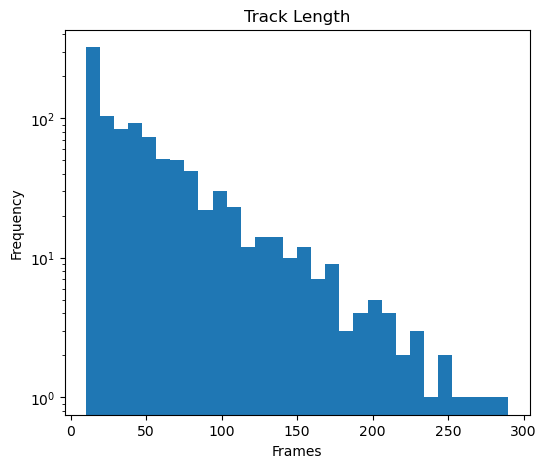

In [8]:
plt.figure(figsize=(6,5))
plt.hist(track_lens, bins=30)
plt.ylabel("Frequency")
plt.xlabel("Frames")
plt.title("Track Length")
plt.yscale('log')
plt.show()

In [9]:
windowSizeAr = [25] # Size of sliding window to get sets (number of distances)
numHiddenAr = [400] # Number of hidden units

datasetsize = 1000
train_fraction = 0.7
val_fraction = 0.2
test_fraction = 0.1
train_size = int(datasetsize*train_fraction)
val_size   = int(datasetsize*val_fraction  )
test_size  = int(datasetsize*test_fraction )

epochs = 50
batch_size = 256
maxOrder = 2
shift = 2
learning_rate = 1e-3

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 5, verbose = 1, mode = 'auto')
accTrain = np.empty((len(windowSizeAr), len(numHiddenAr)))
accTest  = np.empty((len(windowSizeAr), len(numHiddenAr)))

checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=int(train_size))

number_classes = len(diffusion_coefficients) + len(hurst_coefficients)

Import a bunch of pre- and post-processing functions.

In [10]:
def getMeanMSDs(x, y, maxOrder, shift):
    #print("x2: ", x)

    D= []
    for trackX, trackY in zip(x, y):
        dTrack = []
        for order in range(1, maxOrder + 1):
            dOrder = []
            for j in range(len(trackX) - order):
                dOrder.append(np.sqrt((trackX[j + order] - trackX[j]) ** 2 + (trackY[j + order] - trackY[j]) ** 2))
            dTrack.append(dOrder)
        D.append(dTrack)

    dVec = []
    for track in D:
        vector = []
        for order in range(1, maxOrder + 1):
            v = []
            dO = track[order - 1]

            for i in range(len(track[0])):
                if order % 2 == 0:
                    iStart = (i - shift - ((order - 1) // 2))
                    iEnd = iStart + (2 * shift) - 1
                else:
                    iStart = (i - shift - (order // 2))
                    iEnd = iStart + (2 * shift)

                if iStart < 0:
                    iStart = 0

                if iEnd > (len(track[0]) - 1):
                    iEnd = len(track[0]) - 1

                meanPoint = np.mean(dO[iStart:(iEnd + 1)])
                v.append(meanPoint)
            vector.append(v)
        dVec.append(vector)

    return dVec

def getMeanMSDs1Track(x, y, maxOrder, shift):
    #print("x2: ", x)

    D= []
    dTrack = []
    for order in range(1, maxOrder + 1):
        dOrder = []
        for j in range(len(x) - order):
            dOrder.append(np.sqrt((x[j + order] - x[j]) ** 2 + (y[j + order] - y[j]) ** 2))
        dTrack.append(dOrder)
    D.append(dTrack)

    dVec = []
    for track in D:
        vector = []
        for order in range(1, maxOrder + 1):
            v = []
            dO = track[order - 1]

            for i in range(len(track[0])):
                if order % 2 == 0:
                    iStart = (i - shift - ((order - 1) // 2))
                    iEnd = iStart + (2 * shift) - 1
                else:
                    iStart = (i - shift - (order // 2))
                    iEnd = iStart + (2 * shift)

                if iStart < 0:
                    iStart = 0

                if iEnd > (len(track[0]) - 1):
                    iEnd = len(track[0]) - 1

                meanPoint = np.mean(dO[iStart:(iEnd + 1)])
                v.append(meanPoint)
            vector.append(v)
        dVec.append(vector)

    return dVec

def getCoord(x_, y_):
    
    coordXY = []
    
    for trackX, trackY in zip(x_, y_):
        coxy = []
        
        for j in range(len(trackX) - 1):
            coxy.append([trackX[j], trackY[j], trackX[j + 1], trackY[j + 1]])
        coordXY.append(coxy)
        
    return coordXY

def getCoord1Track(x_, y_):
    
    coordXY = []
    
    coxy = []
    
    for j in range(len(x_) - 1):
        coxy.append([x_[j], y_[j], x_[j + 1], y_[j + 1]])
    coordXY.append(coxy)
    
    return coordXY

# function that gets number of sets for maximum windowsize in windowSizeAr

def getMaxSets(trs, windowSizeAr):
    
    windowMax = max(windowSizeAr)
    maxNum = 0
    
    for state in trs:
        for j in range(len(state)- windowMax + 1):
            maxNum += 1
            
    return maxNum

def getFeatVec(d_, x_, y_, addFeat, maxOrder, shift):
    
    if 'meanMSD' in addFeat:
        dMeanVec = getMeanMSDs(x_, y_, maxOrder, shift)
        
    if 'xy' in addFeat:
        xy = getCoord(x_, y_)
    print("xy.shape: ", np.array(xy).shape)
    print("d_.shape: ", np.array(d_).shape)
    
    featVec_ = []
    for i in range(len(d_)):
        featTrack = []
        for j in range(len(d_[i])):
            featPoint = []
            featPoint.append(d_[i][j])

            if 'meanMSD' in addFeat:             
                for order in range(maxOrder):
                    featPoint.append(dMeanVec[i][order][j])

            if 'xy' in addFeat:            
                featPoint.append(xy[i][j][0])
                featPoint.append(xy[i][j][1])
                featPoint.append(xy[i][j][2])
                featPoint.append(xy[i][j][3])

            featTrack.append(featPoint)
        featVec_.append(featTrack)
    
    return featVec_

def getFeatVec1Track(d, x, y, addFeat, maxOrder, shift):
    #print("x3: ", x)
    
    if 'meanMSD' in addFeat:
        dMeanVec = getMeanMSDs1Track(x, y, maxOrder, shift)[0]
        
    if 'xy' in addFeat:
        xy = getCoord1Track(x, y)[0]

    tot = 0
    featVec = []
    featTrack = []
    for j in range(len(d)):
        featPoint = []
        featPoint.append(d[j])

        if 'meanMSD' in addFeat:             
            for order in range(maxOrder):
                featPoint.append(dMeanVec[order][j])

        if 'xy' in addFeat:            
            featPoint.append(xy[j][0])
            featPoint.append(xy[j][1])
            featPoint.append(xy[j][2])
            featPoint.append(xy[j][3])
        tot += 1
        featTrack.append(featPoint)
    featVec.append(featTrack)
    
    #print("len of featVec: ", tot)
    return featVec

def getFeatTrsSets(feat_, trs_, windowSize, addFeat, maxOrder):

    featSets_ = []
    trsSets_ = []

    numFeat = 1 + ('meanMSD' in addFeat) * maxOrder + ('xy' in addFeat) * 4
    
    #print("len(feat_) in getFeatTrsSets: ", len(feat_))
    for featVec_, state_ in zip(feat_, trs_):
        #print("len(featVec_): ", len(featVec_))
        for j in range(len(featVec_) - windowSize + 1):
            featSets_.append(featVec_[j:j + windowSize])
            trsSets_.append(state_[j:j + windowSize])
            
    featSetsReshape = np.array(featSets_).reshape((len(featSets_), windowSize, numFeat))
    trsSetsReshape = np.array(trsSets_).reshape((len(trsSets_), windowSize, 1))
    
    # Normalization
    if 'xy'in addFeat:
        for i in range(len(featSetsReshape)):
            for j in range(windowSize):
                featSetsReshape[i, j, -4] = featSetsReshape[i, j, -4] - featSetsReshape[i, 0, -4]
                featSetsReshape[i, j, -3] = featSetsReshape[i, j, -3] - featSetsReshape[i, 0, -3]
                featSetsReshape[i, j, -2] = featSetsReshape[i, j, -2] - featSetsReshape[i, 0, -4]    
                featSetsReshape[i, j, -1] = featSetsReshape[i, j, -1] - featSetsReshape[i, 0, -3]
    
        
    return featSetsReshape, trsSetsReshape, numFeat

def getFeatSets(feat_, windowSize, addFeat, maxOrder):

    featSets_ = []

    numFeat = 1 + ('meanMSD' in addFeat) * maxOrder + ('xy' in addFeat) * 4

    for featVec_ in feat_:
        for j in range(len(featVec_) - windowSize + 1):
            featSets_.append(featVec_[j:j + windowSize])
            #print("appending: ", np.array(featVec_[j:j + windowSize]).shape)
            #for j in range(len(featVec_) - windowSize + 1, len(featVec_)):
            #
            #if len(np.flip(featVec_[j - windowSize:j])) > 0:
            #    toappend = np.flip(featVec_[j - windowSize:j+1])
            #    for i in range(windowSize - len(toappend)):
            #        toappend = np.append(toappend, toappend[0])
            #    featSets_.append(toappend)
            
    #print("sizeeeee: ", len(featSets_))


    featSetsReshape = np.array(featSets_).reshape((len(featSets_), windowSize, numFeat))
    
    # Normalization
    if 'xy'in addFeat:
        for i in range(len(featSetsReshape)):
            for j in range(windowSize):
                featSetsReshape[i, j, -4] = featSetsReshape[i, j, -4] - featSetsReshape[i, 0, -4]
                featSetsReshape[i, j, -3] = featSetsReshape[i, j, -3] - featSetsReshape[i, 0, -3]
                featSetsReshape[i, j, -2] = featSetsReshape[i, j, -2] - featSetsReshape[i, 0, -4]    
                featSetsReshape[i, j, -1] = featSetsReshape[i, j, -1] - featSetsReshape[i, 0, -3]

    return featSetsReshape
    

# Function that zips 2 arrays of same length and shuffles them
def shuffle2zip(A, B):
    Z = list(zip(A, B))
    np.random.shuffle(Z)
    Ashuf, Bshuf = zip(*Z)
    
    Ashuf = np.array(Ashuf)
    Bshuf = np.array(Bshuf)
    
    return Ashuf, Bshuf

# Function to split in training and test data

def splitTrainTest(featSets, trsSets, testpercentage = 0.1):
    numtrain = round((1 - testpercentage) * len(featSets))
    featTrain, trsTrain = featSets[:numtrain], trsSets[:numtrain]
    featTest, trsTest = featSets[numtrain:], trsSets[numtrain:]
    return (featTrain, trsTrain), (featTest, trsTest)

def getDistTrS(x, y, s):    
    
    distances = []
    trStates = []

    for trackX, trackY, trackS in zip(x, y, s):
        dist = []
        trst = []        
        
        for j in range(len(trackX) - 1):            
            dist.append(np.sqrt((trackX[j + 1] - trackX[j]) ** 2 + (trackY[j + 1] - trackY[j]) ** 2))

            #if trackS[j + 1] != trackS[j]:
            #    trst.append(1) # state 1 for switching from state 0 to 1 or 1 to 0
            #elif trackS[j] == 0:
            #    trst.append(0) # state 0 for staying in state 0
            #elif trackS[j] == 1:
            #    trst.append(2) # state 2 for staying in state 1
            #else:
            #    print("ERRORORROROROR")
            trst.append(trackS[j])
        
        distances.append(dist)
        trStates.append(trst)
    
    return distances, trStates

In [11]:
print('Data loaded')

d, trs = getDistTrS(X_tracks, Y_tracks, S_tracks)
feat = getFeatVec(d, X_tracks, Y_tracks, addFeat, maxOrder, shift)

print('Features extracted')

maxSets = getMaxSets(trs, windowSizeAr)

Data loaded


/tmp/ipykernel_32828/4085011522.py:127: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print("xy.shape: ", np.array(xy).shape)
/tmp/ipykernel_32828/4085011522.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print("d_.shape: ", np.array(d_).shape)


xy.shape:  (1000,)
d_.shape:  (1000,)
Features extracted



Windowsize = 25 (in total 30624 sets, took 30624 sets)
h = 400
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 25, 800)           1305600   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 25, 4)             3204      
Total params: 1,308,804
Trainable params: 1,308,804
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
96/96 [==============================] - 8s 63ms/step - loss: 1.2625 - accuracy: 0.3984 - val_loss: 0.7568 - val_accuracy: 0.6489
Epoch 2/50
 4/96 [>.............................] - ETA: 4s - loss: 0.7494 - accuracy: 0.6470
Epoch 00002: saving model to training_2/cp-0002.ckpt
96/96 [==============================] - 5s 56ms/step - loss: 0.6997 - accuracy: 0.6873 - val_loss: 0.5443 - val_accuracy: 0.7757
Epoch 3/50
96/96 [=

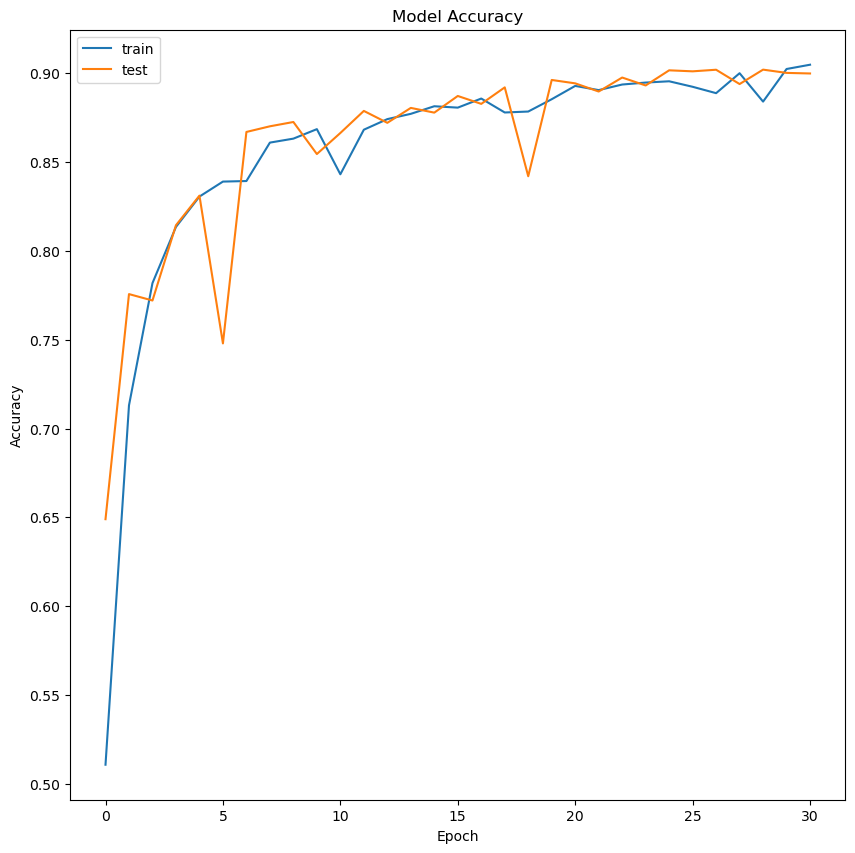

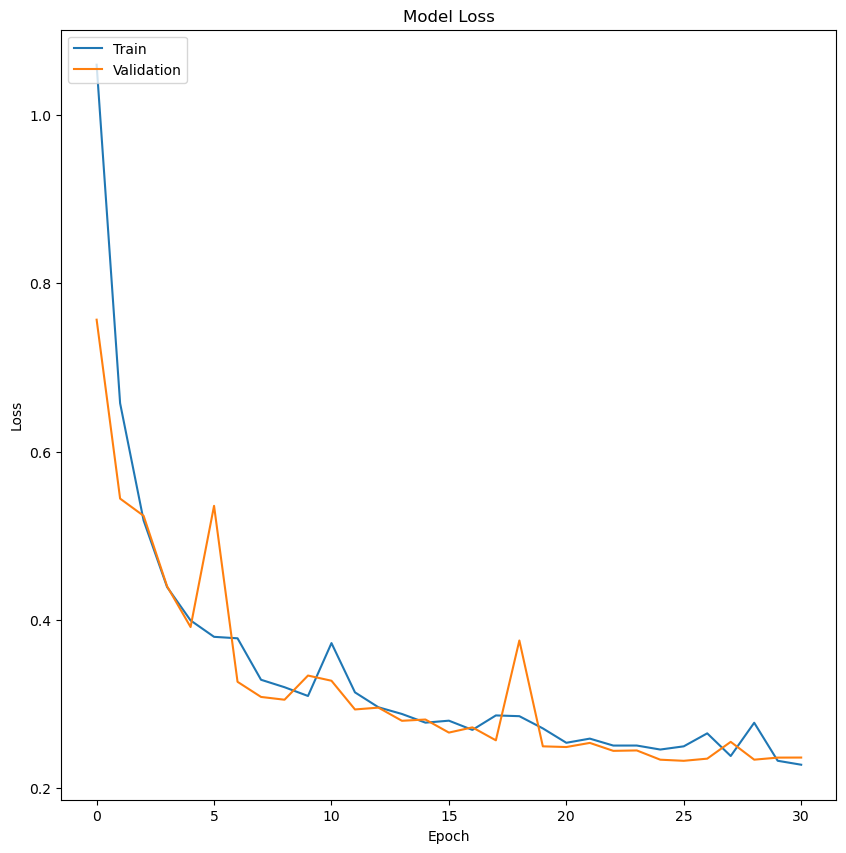

In [15]:
for windowSize in windowSizeAr: 

    # Creating sets of size windowSize (sliding window)
    featSets, trsSets, numFeat = getFeatTrsSets(feat.copy(), trs.copy(), windowSize, addFeat, maxOrder)
    
    # Classes 0 / 1 / 2 need to be converted into 1 0 0 / 0 1 0 / 0 0 1
    trs2class = keras.utils.to_categorical(trsSets, num_classes = number_classes).reshape(len(trsSets), windowSize, number_classes)

    # Split data into train and test set (with shuffeling)
    featShuf, trsShuf = shuffle2zip(featSets, trs2class)
    featMax, trsMax = featShuf[:maxSets], trsShuf[:maxSets]
    featMaxShuf, trsMaxShuf = shuffle2zip(featMax, trsMax)

    (featTrain, trsTrain), (featTest, trsTest) = splitTrainTest(featMaxShuf, trsMaxShuf,\
                                                                testpercentage = val_fraction)

    #with tf.device('/GPU:1'):
    with tf.device('/CPU:0'):
        
        (featTrain, trsTrain), (featTest, trsTest) = (featTrain, trsTrain), (featTest, trsTest)
        
        print('\nWindowsize = %s (in total %s sets, took %s sets)' %(windowSize, len(featSets), maxSets))

        for numHidden in numHiddenAr:
            print('h = %s' %(numHidden))

            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

            # Creating model
            model = Sequential()
            model.add(Bidirectional(LSTM(numHidden, return_sequences = True), input_shape = (windowSize, numFeat), merge_mode = 'concat'))
            model.add(TimeDistributed(Dense((number_classes), activation = 'softmax'))) # Softmax to get 'probability distribution' 
            model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics = ['accuracy'])
            print(model.summary())
            
            model.save_weights(checkpoint_path.format(epoch=0))


            # Training
            history = model.fit(featTrain, trsTrain.astype(int), validation_data=(featTest, trsTest.astype(int)), callbacks = [earlystop, cp_callback], epochs = epochs,\
                        batch_size = batch_size, verbose = 1, shuffle = True)

            # Predicting on test set and convert 1 0 0 / 0 1 0 / 0 0 1 back into 0 / 1 / 2
            predicted = model.predict(featTest)
            trsPred   = predicted.argmax(axis = 2) # Predicted transition states
            trsReal   = trsTest.argmax(axis = 2) # Real transition states

            # Get accuracy on train and test data
            accTrain[windowSizeAr.index(windowSize), numHiddenAr.index(numHidden)] =\
            np.array(history.history['accuracy'][-5:]).mean()

            total = 0
            accurate = 0
            for pred, real in zip(trsPred, trsReal):
                for p, r in zip(pred, real):
                    total += 1
                    if p == r:
                        accurate += 1
            accTest[windowSizeAr.index(windowSize), numHiddenAr.index(numHidden)] = accurate / total

            gradList = []
            for pred, real in zip(trsPred, trsReal):
                grad = []
                for p, r in zip(pred, real):
                    if p == r:
                        grad.append(1)
                    else:
                        grad.append(0)
                gradList.append(grad)  
                
            model.save_weights(checkpoint_path.format(epoch=len(history.history['accuracy'])))

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title("Model Accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title("Model Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
        

Now let's output the tracks and their predicted states into a csv file.

In [16]:
df["LSTM_PREDICTED_STATE"] = -1

allOfTracks, trackNames = np.empty(shape=(0,25,7)), []
for kk, track in enumerate(np.unique(df['TRACK_ID'])[:10000]):
    if kk % 100 == 0:
        print("track / total: ", kk, " / ", len(np.unique(df['TRACK_ID'])))
    trs_tbt = []
    df_ = df.loc[df['TRACK_ID'] == track, ['POSITION_X', 'POSITION_Y']]
    x_tbt, y_tbt = df_['POSITION_X'].to_numpy(), df_['POSITION_Y'].to_numpy()
    d_tbt = np.sqrt((x_tbt[1:] - x_tbt[:-1])**2 + (y_tbt[1:] - y_tbt[:-1])**2)
    feetVec = np.array(getFeatVec1Track(d_tbt, x_tbt, y_tbt, addFeat, maxOrder, shift))

    featSet = getFeatSets(feetVec.copy(), windowSize, addFeat, maxOrder)
    
    add = 0
    if feetVec.shape[1] < windowSize:
        for i in range(windowSize - feetVec.shape[1]):
            feetVec = np.append(feetVec, np.expand_dims(feetVec[:,-1,:], axis=0), axis=1)
            add += 1
        featSet = feetVec 
    
    for i in range(featSet.shape[0]):
        trackNames.append(track)
    
    predicted_state = model.predict(featSet, verbose=0).argmax(axis=2)

    for i in range(featSet.shape[0]):
        trs_tbt.append(predicted_state[i,0])
    for i in range(feetVec.shape[1] - featSet.shape[0] - add):
        trs_tbt.append(predicted_state[-1,i])
    trs_tbt.append(trs_tbt[-1])


    df.loc[df['TRACK_ID'] == track, "LSTM_PREDICTED_STATE"] = trs_tbt

df.to_csv("simulated_and_classified_tracks.csv")

track / total:  0  /  1000
track / total:  100  /  1000
track / total:  200  /  1000
track / total:  300  /  1000
track / total:  400  /  1000
track / total:  500  /  1000
track / total:  600  /  1000
track / total:  700  /  1000
track / total:  800  /  1000
track / total:  900  /  1000
